In [1]:
import numpy as np
import statistics
from Bio.SeqUtils import GC

In [2]:
def padding_sequence(seq, max_len = 501, repkey = 'N'):
    seq_len = len(seq)
    if seq_len < max_len:
        gap_len = max_len -seq_len
        new_seq = seq + repkey * gap_len
    else:
        new_seq = seq[:max_len]
    return new_seq

In [3]:
def get_RNA_seq_concolutional_array(seq, motif_len = 4):
    seq = seq.replace('U', 'T')
    alpha = 'ACGT'
    #for seq in seqs:
    #for key, seq in seqs.iteritems():
    row = (len(seq) + 2*motif_len - 2)
    new_array = np.zeros((row, 4))
    for i in range(motif_len-1):
        new_array[i] = np.array([0.25]*4)
    
    for i in range(row-3, row):
        new_array[i] = np.array([0.25]*4)
        
    #pdb.set_trace()
    for i, val in enumerate(seq):
        i = i + motif_len-1
        if val not in 'ACGT':
            new_array[i] = np.array([0.25]*4)
            continue
        #if val == 'N' or i < motif_len or i > len(seq) - motif_len:
        #    new_array[i] = np.array([0.25]*4)
        #else:
        try:
            index = alpha.index(val)
            new_array[i][index] = 1
        except:
            pdb.set_trace()
        #data[key] = new_array
    return new_array


In [4]:
def get_bag_data_1_channel(data, max_len = 501):
    bags = []
    seqs = data["seq"]
    labels = data["Y"]
    for seq in seqs:
        #pdb.set_trace()
        #bag_seqs = split_overlap_seq(seq)
        
        # replace each sequence with the sequence followed by N's until the length is equal to max_len
        bag_seq = padding_sequence(seq, max_len = max_len)
        #flat_array = []
        bag_subt = []
        #for bag_seq in bag_seqs:
        
        # turn the padded sequence into a 2-D array, where a row of the array is [.25,.25,.25,.25] for an N, and [1,0,0,0] for an A, [0,1,0,0] for an T, and so on
        tri_fea = get_RNA_seq_concolutional_array(bag_seq)
        bag_subt.append(tri_fea.T)

        
        bags.append(np.array(bag_subt))
    
        
    return bags, labels

In [5]:
def read_seq_graphprot(seq_file, label = 1):
    seq_list = []
    labels = []
    seq = ''
    with open(seq_file, 'r') as fp:
        for line in fp:
            if line[0] == '>':
                name = line[1:-1]
            else:
                seq = line[:-1].upper()
                seq = seq.replace('T', 'U')
                seq_list.append(seq)
                labels.append(label)
    
    return seq_list, labels

In [6]:
def read_data_file(posifile, negafile = None, train = True):
    data = dict()
    seqs, labels = read_seq_graphprot(posifile, label = 1)
    if negafile:
        seqs2, labels2 = read_seq_graphprot(negafile, label = 0)
        seqs = seqs + seqs2
        labels = labels + labels2
    # made a dictionary, "seq" key has a list of sequences as values, "Y" key has a list of 0's and 1's as values inidicating if the corresponding sequence is bound or not
    data["seq"] = seqs 
    data["Y"] = np.array(labels)
    
    return data

In [7]:
def get_data(posi, nega = None, channel = 7,  window_size = 101, train = True):
    data = read_data_file(posi, nega, train = train)
    if channel == 1:
        # pad the sequences and turn them into one-hot-encoded 2D arrays
        train_bags, label = get_bag_data_1_channel(data, max_len = window_size)

    else:
        train_bags, label = get_bag_data(data, channel = channel, window_size = window_size)
    
    return train_bags, label

In [8]:
# TASK 1: data exploration
train_data_dict = read_data_file('./CLIPSEQ_AGO2.train.positives.fa', './CLIPSEQ_AGO2.train.negatives.fa', train=True)
test_data_dict = read_data_file('./CLIPSEQ_AGO2.ls.positives.fa', './CLIPSEQ_AGO2.ls.negatives.fa', train=False)

In [9]:
print("The number of training samples is {} and the number of testing samples is {}".format(len(train_data_dict["seq"]), len(test_data_dict["seq"])))

sum = 0
gc_sum = 0
lens = []
for seq in train_data_dict["seq"]:
    sum += len(seq)
    gc_sum += GC(seq)
    lens.append(len(seq))
avg_seq_len = sum/len(train_data_dict["seq"])
avg_gc = gc_sum/len(train_data_dict["seq"])
sd = statistics.pstdev(lens)



print("The average sequence length is {} basepairs and SD {}".format(avg_seq_len, sd))
print("Average GC content {}".format(avg_gc))
pos = train_data_dict["Y"].sum()
pos_test = test_data_dict["Y"].sum()
print("The number of positive training samples is {}, negative {}, positive testing {}, negative testing {}".format(pos, len(train_data_dict["Y"])-pos, pos_test, len(test_data_dict["Y"])-pos_test ))                                                                                                         

The number of training samples is 92346 and the number of testing samples is 1000
The average sequence length is 335.3414333051783 basepairs and SD 23.562489201335342
Average GC content 42.81991234259084
The number of positive training samples is 48095, negative 44251, positive testing 500, negative testing 500


In [10]:
train_data_dict_True = read_data_file('./CLIPSEQ_AGO2.train.positives.fa',train=True)
train_data_dict_False = read_data_file('./CLIPSEQ_AGO2.train.negatives.fa',train=True)

In [11]:
sum = 0
gc_sum = 0
lens = []
for seq in train_data_dict_True["seq"]:
    sum += len(seq)
    gc_sum += GC(seq)
    lens.append(len(seq))
avg_seq_len = sum/len(train_data_dict_True["seq"])
avg_gc = gc_sum/len(train_data_dict_True["seq"])
sd = statistics.pstdev(lens)



print("The average sequence length is {} basepairs and SD {} for Positive Test Data".format(avg_seq_len, sd))
print("Average GC content {} of Positive Test Data".format(avg_gc))

The average sequence length is 332.4178396922757 basepairs and SD 29.05655125223127 for Positive Test Data
Average GC content 40.52043249400809 of Positive Test Data


In [12]:
sum = 0
gc_sum = 0
lens = []
for seq in train_data_dict_False["seq"]:
    sum += len(seq)
    gc_sum += GC(seq)
    lens.append(len(seq))
avg_seq_len = sum/len(train_data_dict_False["seq"])
avg_gc = gc_sum/len(train_data_dict_False["seq"])
sd = statistics.pstdev(lens)



print("The average sequence length is {} basepairs and SD {} for Negative Test Data".format(avg_seq_len, sd))
print("Average GC content {} of Negative Test Data".format(avg_gc))

The average sequence length is 338.51899392104133 basepairs and SD 14.886199718920112 for Negative Test Data
Average GC content 45.319143621377904 of Negative Test Data


In [14]:
def numMotif(motif,string):
    return(len(string.split(motif)))

In [15]:
from tqdm import tqdm_notebook as tq
# Progress bar

In [16]:
from joblib import Parallel, delayed 
# Do code in parallel, faster

In [22]:
import matplotlib.pyplot as plt

In [17]:
trainTrue = read_data_file('./CLIPSEQ_AGO2.train.positives.fa',train=False)
trainFalse = read_data_file('./CLIPSEQ_AGO2.train.negatives.fa',train=False)

In [18]:
def sumLst(lst):
    n=0
    for elem in lst:
        n+=elem
    return n

In [19]:
def posKmers(size=5,base=[]):
    if size<=0:
        return base
    else:
        size-=1
        base=allShuffles(base)
        return posKmers(size,base)
    
def allShuffles(lst,base=['A','C','G','U']):
    if len(lst)==0:
        return base
    shuf=[]
    for e in base:
        for elem in lst:
            elem2=e+elem
            shuf.append(elem2)
    return shuf

In [33]:
motifTrue=[]
motifsUsed=[]
motifs=posKmers(4)
for motif in tq(motifs):
    inputs1=trainTrue['seq']
    numMot = Parallel(n_jobs=7)(delayed(numMotif)(motif,seq) for seq in inputs1)
    avgTrue=sumLst(numMot)/len(inputs1)

    inputs2=trainFalse['seq']
    numMot = Parallel(n_jobs=7)(delayed(numMotif)(motif,seq) for seq in inputs2)
    avgFalse=sumLst(numMot)/len(inputs2)
    if avgTrue-avgFalse>0.7:
        motifTrue.append(avgTrue-avgFalse)
        motifsUsed.append(motif)

<ipython-input-33-8a5e042e0cf1>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for motif in tq(motifs):


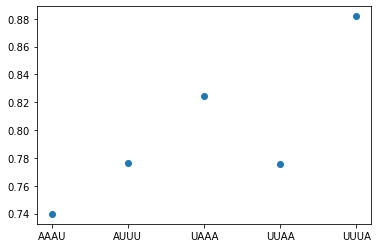

In [34]:
xs=motifsUsed
plt.scatter(xs,motifTrue)
plt.show()

# Motifs that are more likely in positive bindings as opposed to negatvie

In [36]:
motifsUsed

['AAAU', 'AUUU', 'UAAA', 'UUAA', 'UUUA']

In [35]:
goodMotifs=['AAAU', 'AUUU', 'UAAA', 'UUAA', 'UUUA']

['AAAU', 'AUUU', 'UAAA', 'UUAA', 'UUUA']

In [ ]:
# read in the data 
f, l = get_data('./CLIPSEQ_AGO2.train.positives.fa', './CLIPSEQ_AGO2.train.negatives.fa', channel=1)

In [ ]:
f_test, l_test = get_data('./CLIPSEQ_AGO2.ls.positives.fa','CLIPSEQ_AGO2.ls.negatives.fa', channel=1, train=False)

In [ ]:
f = np.array(f)
f = np.swapaxes(f, -1, 1)

In [ ]:
f_test = np.array(f_test)
f_test = np.swapaxes(f_test, -1, 1)